# Ejercicio 24
## Juan Pablo Martinez Piazuelo

# Parte 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix
from sklearn.model_selection import ShuffleSplit

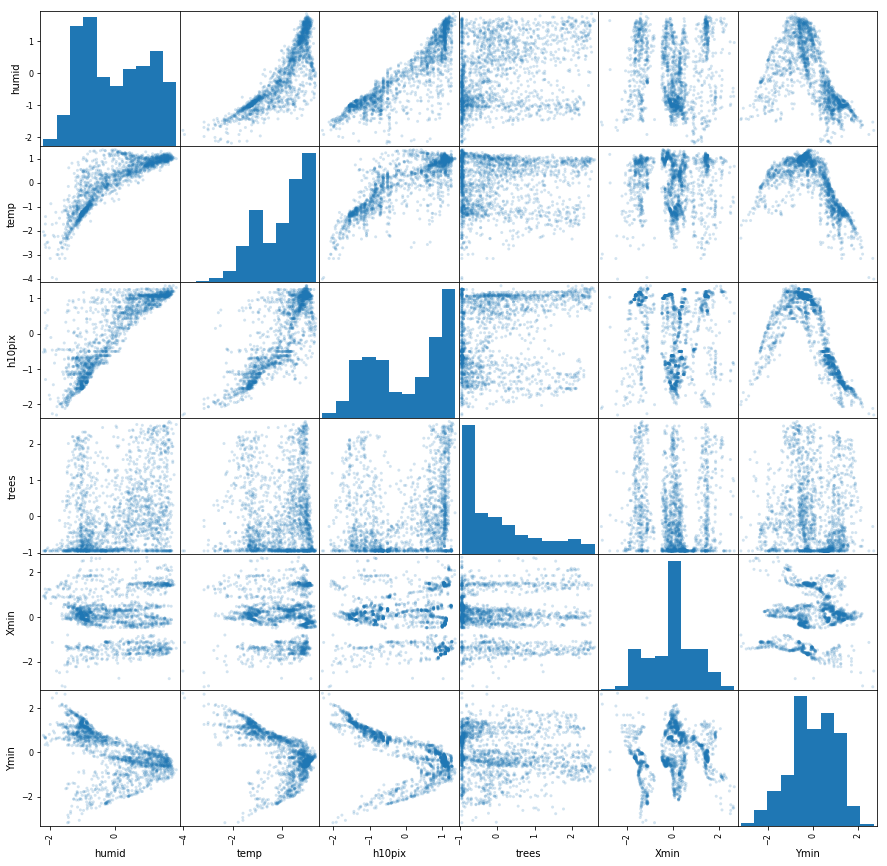

In [2]:
data = pd.read_csv('dengue.csv',sep=',').dropna()
keys = ['humid', 'temp' , 'h10pix', 'trees' , 'Xmin', 'Ymin']
X = data[keys].astype(float)

X = StandardScaler().fit_transform(X)
X = pd.DataFrame(data=X,index=np.arange(X.shape[0]),columns=keys)
scatter_matrix(X, alpha=0.2, figsize=(15, 15), diagonal='hist');

## Main functions for clustering

In [3]:
def run_clustering(data,max_clusters):
    inertias, inertia_deltas = [], []
    for i in np.arange(1,max_clusters):
        kmeans = KMeans(n_clusters=i, random_state=0).fit(data)
        inertia = kmeans.inertia_
        inertias.append(inertia)    

        if(i==1):
            inertia_deltas.append(inertia)
        else:
            delta = old_inertia-inertia
            inertia_deltas.append(delta)

        old_inertia = inertia

    inertia_deltas = np.array(inertia_deltas)/np.amax(inertia_deltas)
    return np.array(inertias), inertia_deltas

def plot_cluster_run(inertias, inertia_deltas, max_clusters, delta_threshold):
    clusters_cut = np.where(inertia_deltas<=delta_threshold)[0][0]

    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.plot(np.arange(1,max_clusters),inertias,marker='o',color='b');
    plt.axvline(x=clusters_cut+1,color='g',linewidth=2,linestyle='dashed',
                label='Threshold at: '+str(delta_threshold*100)+'%')
    scale = 'linear'
    plt.yscale(scale)
    plt.ylabel('Inertia ('+scale+')')
    plt.xlabel('Num. clusters')
    plt.legend()

    plt.subplot(122)
    plt.plot(np.arange(1,max_clusters),inertia_deltas,marker='o',color='r');
    plt.axhline(y=inertia_deltas[clusters_cut],color='g',linewidth=2,linestyle='dashed',
                label='Threshold at: '+str(delta_threshold*100)+'%')
    plt.ylabel('Inertia Delta (normalized)')
    plt.xlabel('Num. clusters');
    plt.legend();

## Run on the number of clusters

In [4]:
max_clusters = 20
inertias, inertia_deltas = run_clustering(X,max_clusters)

## Choose number of clusters

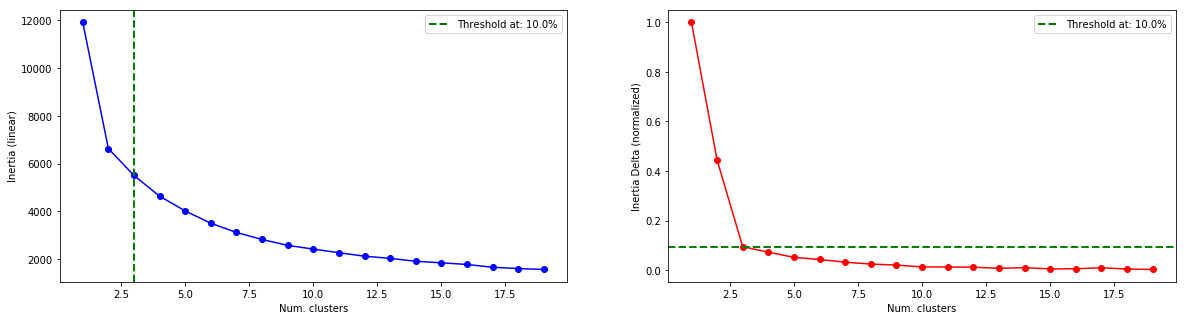

In [5]:
delta_threshold = 0.1 # Porcentaje de corte bajo el cambio en la inercia
plot_cluster_run(inertias, inertia_deltas, max_clusters, delta_threshold)

Con base en el criterio del $10\%$ de cambio en la inercia, a partir de $3$ clusters la inercia cambia en menos del $10\%$. Por lo tanto, se ecoge $3$ como un número de clusters apropiado para estructurar los datos.

## Plotting functions

In [6]:
def two_vars_clusters_subplot(num_clusters,labels,dataframe,var_keys,subplot_idx):
    cs = np.arange(num_clusters)
    xs = dataframe[var_keys[0]].values
    ys = dataframe[var_keys[1]].values
    plt.subplot(5,3,subplot_idx)
    for c in cs:
        idx = np.where(labels==c)
        plt.scatter(xs[idx],ys[idx],marker='+',label='Cluster '+str(c))
        plt.xlabel(var_keys[0])
        plt.ylabel(var_keys[1])
        plt.legend(loc='best')
        
def two_vars_clusters_plot(num_clusters,labels,dataframe,var_keys,size=(10,10)):
    cs = np.arange(num_clusters)
    xs = dataframe[var_keys[0]].values
    ys = dataframe[var_keys[1]].values
    plt.figure(figsize=size)
    for c in cs:
        idx = np.where(labels==c)
        plt.scatter(xs[idx],ys[idx],marker='+',label='Cluster '+str(c))
        plt.xlabel(var_keys[0])
        plt.ylabel(var_keys[1])
        plt.legend(loc='best')

## 2v2 plots with cluster colors

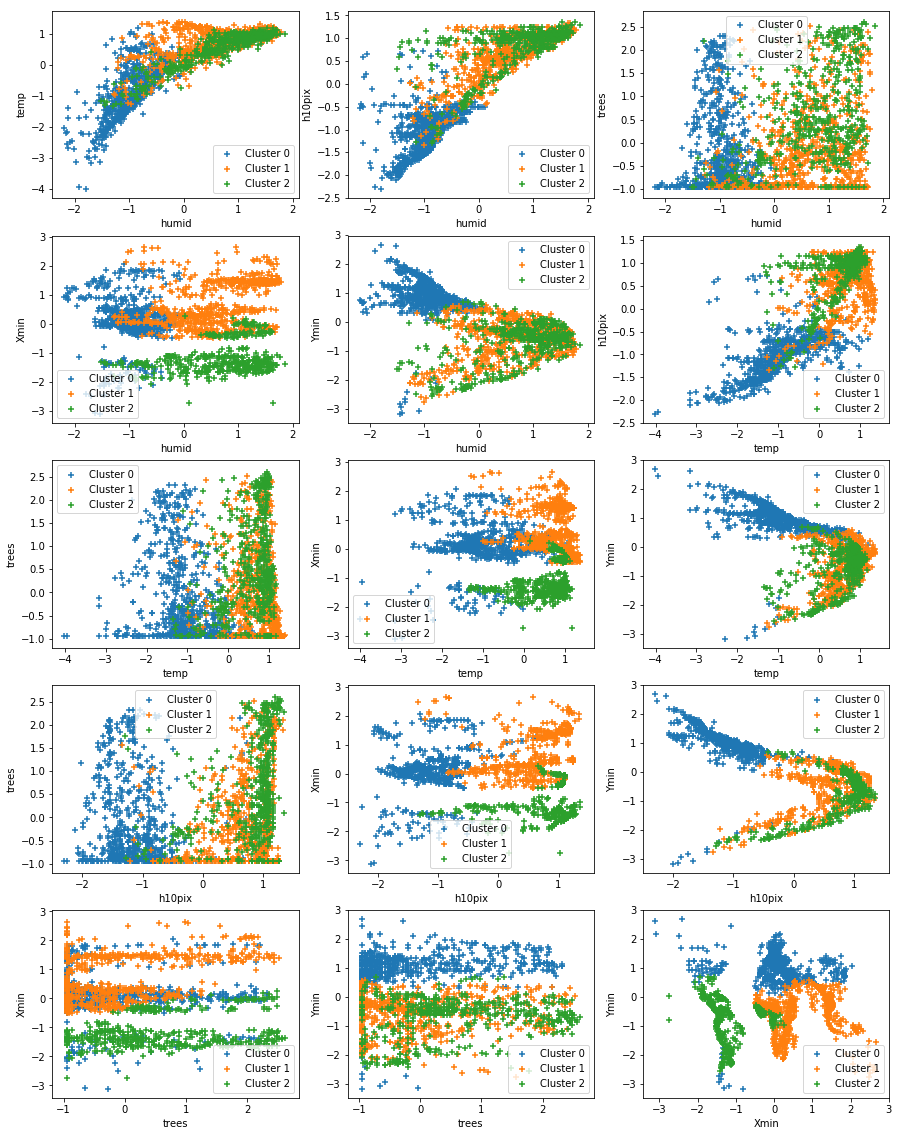

In [7]:
num_clusters = 3
keys = ['humid', 'temp' , 'h10pix', 'trees' , 'Xmin', 'Ymin']
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(X)
labels = kmeans.predict(X)

plt.figure(figsize=(15,20))
k = 1
for ix in range(len(keys)):
    for iy in range(ix+1,len(keys)):
        two_vars_clusters_subplot(num_clusters,labels,X,[keys[ix],keys[iy]],k)
        k+=1

# Parte 2

In [8]:
import time
from datetime import datetime
from sklearn.decomposition import PCA

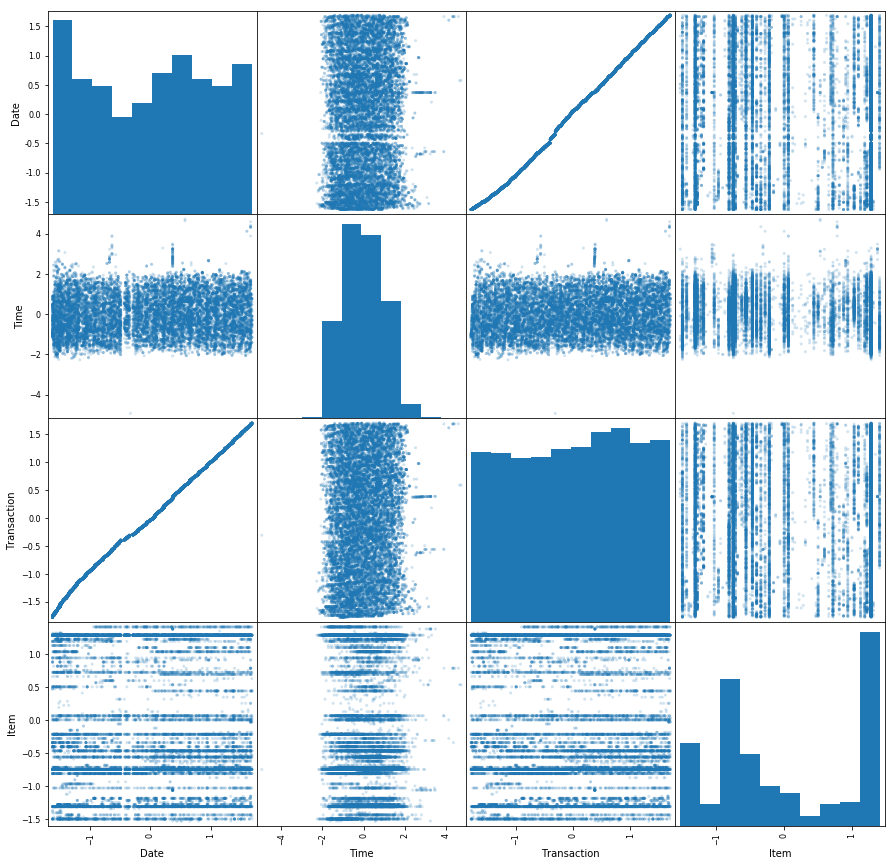

In [9]:
data = pd.read_csv('BreadBasket_DMS.csv',sep=',').dropna()
keys = ['Date','Time','Transaction','Item']

def dates_2_timestamp(date_array):
    dates = np.zeros_like(date_array)
    for i,d in enumerate(date_array):
        dates[i] = time.mktime(datetime.strptime(d, "%Y-%m-%d").timetuple())
    return (dates - np.amin(dates)).astype(float).reshape(-1,1)

def times_2_seconds(time_array):
    times = np.zeros_like(time_array)
    for i,t in enumerate(time_array):
        h,m,s = t.split(':')
        times[i] = int(h)*3600 + int(m)*60 + int(s)
    return (times - np.amin(times)).astype(float).reshape(-1,1)

def categorical_2_num(raw_data):
    data_set = np.array(list(set(raw_data)))
    data = np.zeros_like(raw_data)
    for i,d in enumerate(raw_data):
        data[i] = np.where(data_set==d)[0][0]
    return data.astype(float).reshape(-1,1)

dates = dates_2_timestamp(data[keys[0]].values)
times = times_2_seconds(data[keys[1]].values)
items = categorical_2_num(data[keys[3]].values)
trans = data[keys[2]].values.astype(float).reshape(-1,1)

X = np.hstack((dates,times,trans,items))
X = StandardScaler().fit_transform(X)
X = pd.DataFrame(data=X,index=np.arange(X.shape[0]),columns=keys)

scatter_matrix(X, alpha=0.2, figsize=(15, 15), diagonal='hist');

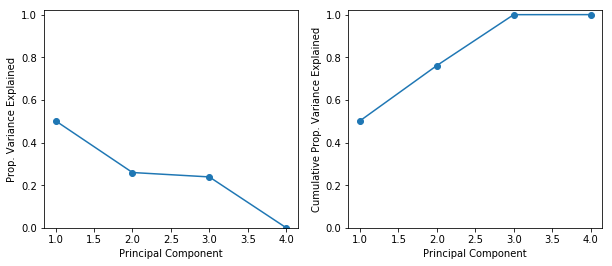

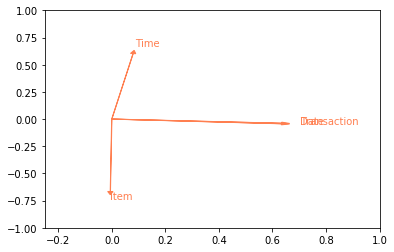

In [10]:
pca = PCA(n_components=4).fit(X)
PVE = pca.explained_variance_ratio_
PCs = pca.components_
keys = ['Date','Time','Transaction','Item']

def plot_PVEs(PVE):
    plt.figure(figsize=(10,4))
    plt.subplot(121)
    plt.plot(np.arange(1,len(PVE)+1),PVE,marker='o')
    plt.ylim(0,1.02)
    plt.ylabel('Prop. Variance Explained')
    plt.xlabel('Principal Component')

    plt.subplot(122)
    plt.plot(np.arange(1,len(PVE)+1),np.cumsum(PVE),marker='o')
    plt.ylim(0,1.02)
    plt.ylabel('Cumulative Prop. Variance Explained')
    plt.xlabel('Principal Component');
    
plot_PVEs(PVE)

plt.figure()
arr_sc = 0.9
for i in range(PCs.shape[1]):
    plt.arrow(0,0,PCs[0,i]*arr_sc,PCs[1,i]*arr_sc,color='coral',head_width=0.02)
    plt.text(PCs[0,i],PCs[1,i],keys[i],color='coral')
    
plt.xlim(-0.25,1)
plt.ylim(-1,1);

De estos resultados se ve que las variables Date y Transaction están relacionadas, y las variables Item y Time también tienen cierta relación en el espacio de PC. Con esto en mente se escogen Transaction y Item como variables principales, con el fin de reducir la dimensionalidad del problema. Aplicar clusters sobre estas variables nos permitirá encontrar que productos se compran juntos en la misma transacción, y, por ende, que productos deberían ponerse cerca en la panadería.

In [11]:
new_keys = ['Transaction','Item']
X_red = X[new_keys]
max_clusters = 20
inertias, inertia_deltas = run_clustering(X_red,max_clusters)

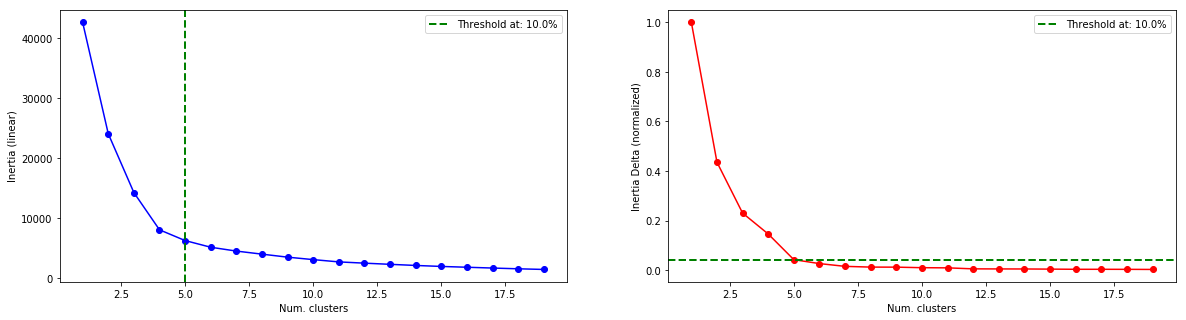

In [12]:
delta_threshold = 0.1 # Porcentaje de corte bajo el cambio en la inercia
plot_cluster_run(inertias, inertia_deltas, max_clusters, delta_threshold)

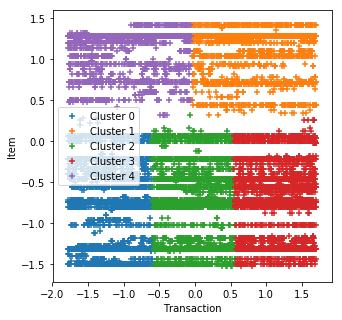

In [13]:
num_clusters = 5
keys = ['Transaction','Item']
X_red = X[keys]
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(X_red)
labels = kmeans.predict(X_red)
two_vars_clusters_plot(num_clusters,labels,X_red,[keys[0],keys[1]],size=(5,5))